# Gravity+ Metrology modulation


### Loading metrology table

In [1]:
using FITSIO,EasyFITS, Plots, Unitful, StatsBase
import PlotlyJS as ply

plotlyjs()
#metrologyHDU=  FITS("GRAVI.2022-07-18T01:00:34.164.fits")[10]
metrologyHDU=  FITS("/Users/ferreol/Data/RawData/GRAVITY+/2022-08-16/GRAVI.2022-08-17T02:02:55.633.fits")[10]

File: /Users/ferreol/Data/RawData/GRAVITY+/2022-08-16/GRAVI.2022-08-17T02:02:55.633.fits
HDU: 10 (name=METROLOGY)
Type: Table
Rows: 171132
Columns: Name          Size   Type     TFORM  
         TIME                 Int32    1J     
         VOLT          (80,)  Float32  80E    
         POWER_LASER          Float32  1E     
         LAMBDA_LASER         Float32  1E     

In [2]:
volt = read(metrologyHDU,"VOLT") * u"V"
time = read(metrologyHDU,"TIME") * 0.001u"ms"  # time is in μs
ncol, ntime = size(volt)

(80, 171132)

The metrology table has 80 columns:
- 4 telescopes
- 5 diodes per telescope (one on each spiders + one on the fiber coupler)
- 2 sides (`FT` and `SC`)
- 2 directions (`x` and `y`)

in `gravi_met.c` line `537` the code to read metrology table is :
```C
    for (side = FT; side <= SC; side++) {
        for (tel = 0; tel < 4; tel++) {
            for (diode = 0; diode < 4; diode++) {
                for (comp = SIN; comp <= COS; comp++) {
                    tacData->volt_lockin_telescope[tel][diode][side][comp] = volt[idx];
                    idx++;
                }
            }
        }
    }
    for (side = FT; side <= SC; side++) {
        for (tel = 0; tel < 4; tel++) {
            for (comp = SIN; comp <= COS; comp++) {
                tacData->volt_lockin_fiber_coupler[tel][side][comp] = volt[idx];
                idx++;
            }
        }
    }
```


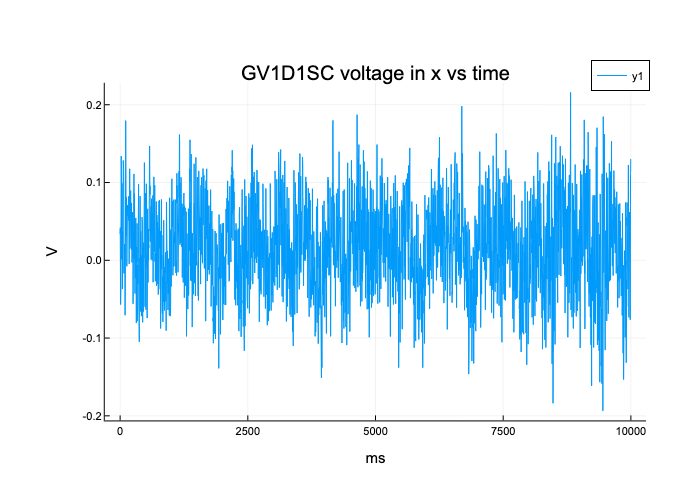

In [3]:
time[1]
n=5000
plot(time[1:n],volt[31,1:n],title="GV1D1SC voltage in x vs time")

The modulation is at 1Hz sampled at 500 measurements per seconds: $\omega=2 \pi$.

The equation of the modulation given by Stefan:
$$ x_{mod}(t)= x_0 + a \sin\left(b \sin\left(\omega \,t + \phi_1\right) + \phi_2\right)$$
$$ y_{mod}(t)= y_0 + a \cos\left(b \sin\left(\omega \,t + \phi_1\right) + \phi_2\right)$$


The modulation can be written in complex as:
$$x'_{mod}(t) = c_0  + a'\,\exp\left( \jmath\,b\,\sin\left( \omega \,t  + \phi_1\right)\right)$$
where $c_0 = x_0 + \jmath\,y_0$ and $a' = a\exp( \jmath\, \phi_2)$

Note that $x'_{mod}(t)$ is linear with respect to $\exp\left( \jmath\,b\,\sin\left( \omega \,t  + \phi_1\right)\right)$ and estimating $c_0$ and $a'$ can be done by linear regression.

In [4]:
chunkSeconds = 60
rv = reshape(volt[:,1:Int(floor(ntime/500))*500],80,500,Int(floor(ntime/500)))
nmax = Int(floor(ntime/500/chunkSeconds))-1

4

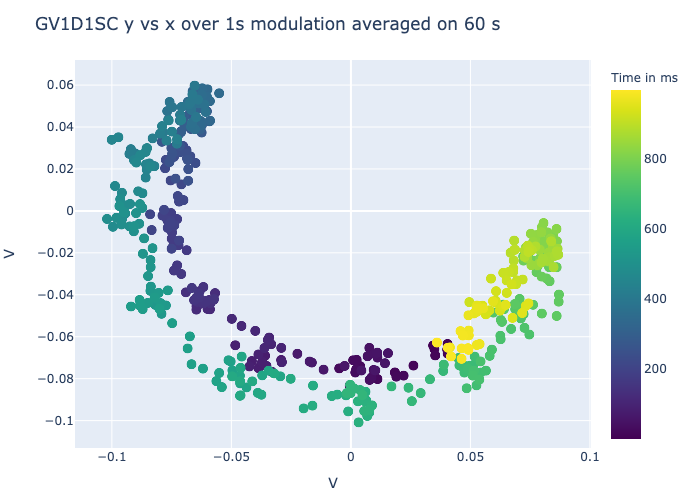

In [5]:
i=1
mrv = mean(rv[:,:,(i*chunkSeconds+1):((i+1)*chunkSeconds)],dims=3)


fig = ply.plot(ply.scattergl(
                    x=ustrip.(mrv[33,:,1]),y=ustrip.(mrv[34,:,1]), mode="markers",
                    marker=ply.attr(size=10, 
                        color=1:2:1000, 
                        colorscale="Viridis", 
                        colorbar=ply.attr(title="Time in ms"),
                        showscale=true)
                ),
                ply.Layout(title="GV1D1SC y vs x over 1s modulation averaged on $chunkSeconds s",
                    xaxis=ply.attr(title="V"),
                    yaxis=ply.attr(title="V"))
)


As the signal is noisy we average the 1s modulation over `chunkSeconds` seconds. The modulation describes an arc when plotting the voltages $y(t)$ vs $x(t)$, as expected. However we can see that the first half is not superposed with the second half meaning that there is another issue not kept by the model. 

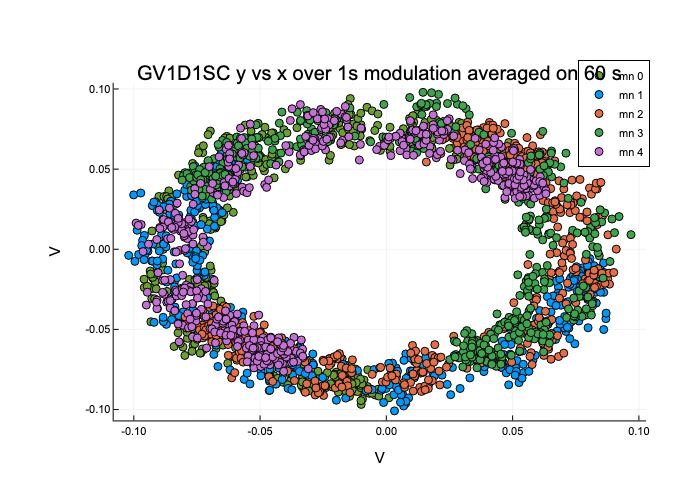

In [6]:
plot(title="GV1D1SC y vs x over 1s modulation averaged on $chunkSeconds s")
for i=0:nmax
    mrv = mean(rv[:,:,(i*chunkSeconds+1):((i+1)*chunkSeconds)],dims=3)
    plot!(mrv[33,:,:],mrv[34,:,:],seriestype=:scatter,color=i,label="mn $i")
end

current()

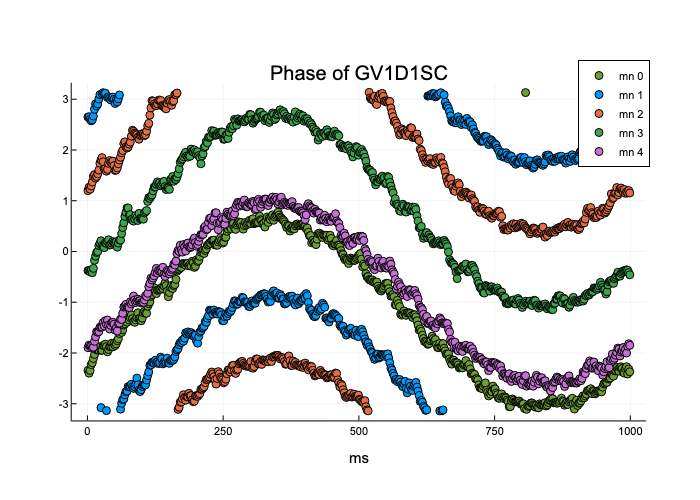

In [7]:
plot(title="Phase of GV1D1SC")
for i=0:nmax
    mrv = mean(rv[:,:,(i*chunkSeconds+1):((i+1)*chunkSeconds)],dims=3)
    plot!((1:2:1000)*u"ms" ,atan.(mrv[33,:,:],mrv[34,:,:]),seriestype=:scatter,color=i,label="mn $i")
end

current()

There is large phase variation of the modulation from a minute to another 

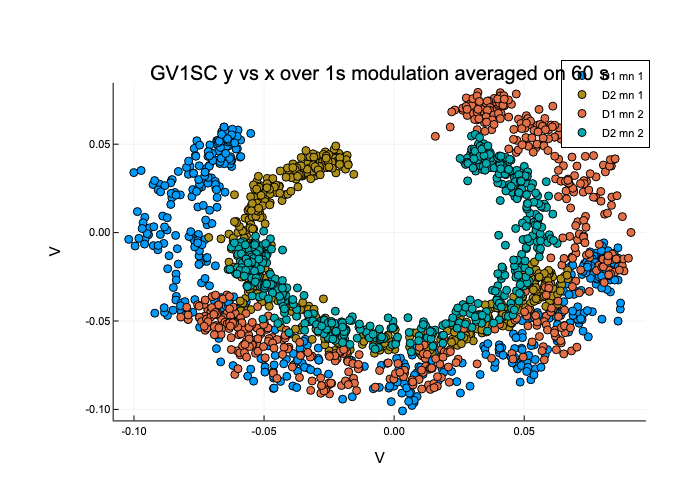

In [8]:
plot(title="GV1SC y vs x over 1s modulation averaged on $chunkSeconds s")
for i=1:2
    mrv = mean(rv[:,:,(i*chunkSeconds+1):((i+1)*chunkSeconds)],dims=3)
    plot!(mrv[33,:,:],mrv[34,:,:],seriestype=:scatter,color=i,scaleratio=1,label="D1 mn $i")
    plot!(mrv[35,:,:],mrv[36,:,:],seriestype=:scatter,color=i+nmax,scaleratio=1,label="D2 mn $i")
end

current()

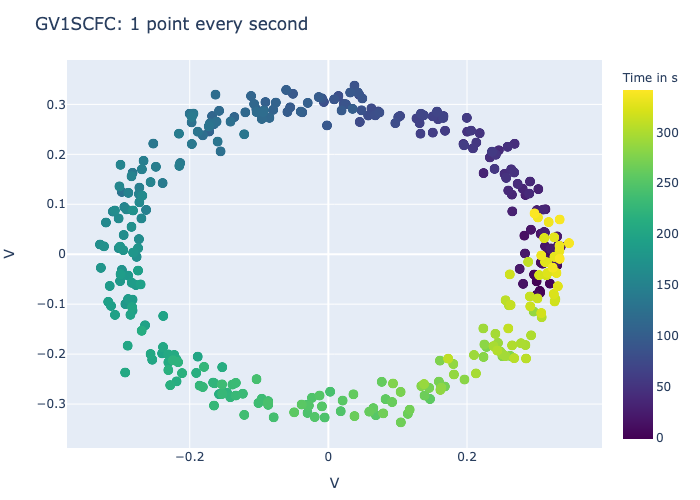

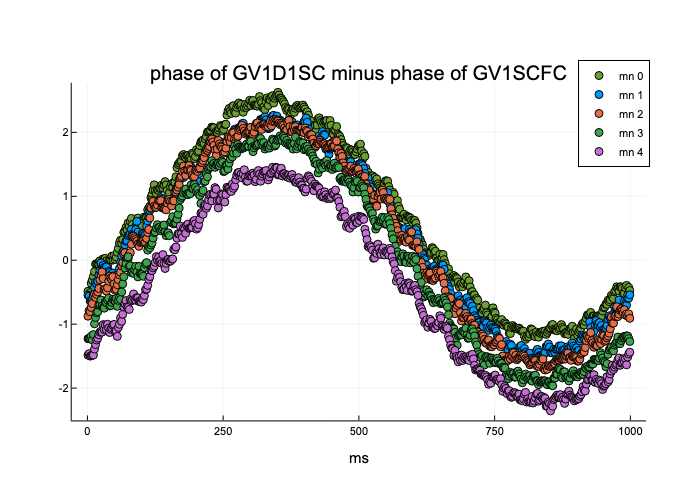

In [10]:
plot(title="phase of GV1D1SC minus phase of GV1SCFC")
for i=0:nmax
    mrv = mean(rv[:,:,(i*chunkSeconds+1):((i+1)*chunkSeconds)],dims=3)
    plot!((1:2:1000)*u"ms",mod.(atan.(mrv[33,:,:],mrv[34,:,:]) .- atan.(mrv[73,:,:],mrv[74,:,:]),2π).-π,seriestype=:scatter,color=i,label="mn $i")
end

current()

This phase variation can be linked to the large phase variation on the fiber coupler output but substracting the phase of the fiber coupler does not completly remove the phase shift from one minute to another.

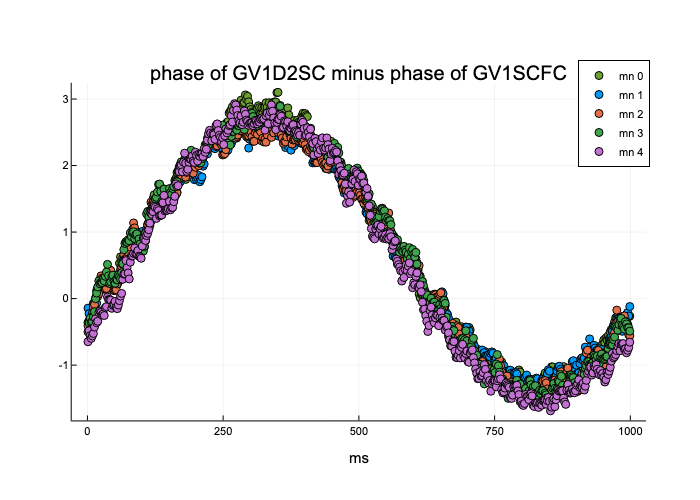

In [11]:
plot(title="phase of GV1D2SC minus phase of GV1SCFC")
for i=0:nmax
    mrv = mean(rv[:,:,(i*chunkSeconds+1):((i+1)*chunkSeconds)],dims=3)
    plot!((1:2:1000)*u"ms",mod.(atan.(mrv[35,:,:],mrv[36,:,:]) .- atan.(mrv[73,:,:],mrv[74,:,:]),2π).-π,seriestype=:scatter,color=i,label="mn $i")
end

current()

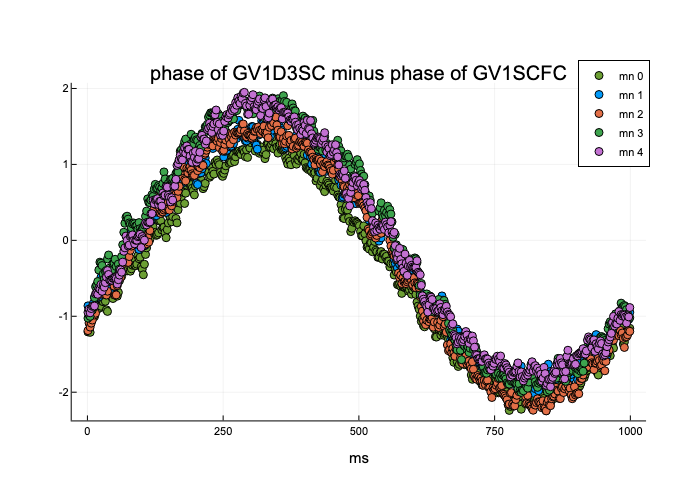

In [12]:
plot(title="phase of GV1D3SC minus phase of GV1SCFC")
for i=0:nmax
    mrv = mean(rv[:,:,(i*chunkSeconds+1):((i+1)*chunkSeconds)],dims=3)
    plot!((1:2:1000)*u"ms",mod.(atan.(mrv[37,:,:],mrv[38,:,:]) .- atan.(mrv[73,:,:],mrv[74,:,:]),2π).-π,seriestype=:scatter,color=i,label="mn $i")
end

current()

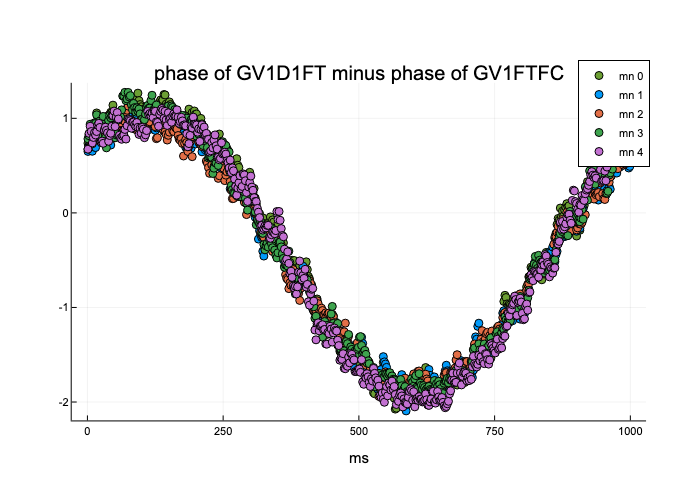

In [13]:
plot(title="phase of GV1D1FT minus phase of GV1FTFC")
for i=0:nmax
    mrv = mean(rv[:,:,(i*chunkSeconds+1):((i+1)*chunkSeconds)],dims=3)
    plot!((1:2:1000)*u"ms",mod.(atan.(mrv[1,:,:],mrv[2,:,:]) .- atan.(mrv[65,:,:],mrv[66,:,:]),2π).-π,seriestype=:scatter,color=i,label="mn $i")
end

current()